In [9]:
import os
from typing import Callable
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"
BLUE_CUBE_CMAP = LinearSegmentedColormap.from_list(
    name="blue_cube",
    colors=["black", "midnightblue", "blue", "steelblue", "slategray", "white"],
)
# Global variables
NCOL = 336  # Number of columns in a CCD frame (overscan included)
NROW = 829  # Number of rows in a CCD frame
OVERSCAN_LENGTH = 42  # Number of overscan pixels

In [10]:
def plot_ccd_image(
    image: np.ndarray,
    cmap: str = None,
    remove_overscan: bool = True,
    orientation: str = "horizontal",
    value_map: Callable = None,
) -> tuple[plt.figure, plt.Axes]:
    global OVERSCAN_LENGTH, BLUE_CUBE_CMAP
    if remove_overscan and isinstance(image, fits.hdu.hdulist.HDUList):
        vertical_image = np.block(
            [
                [image[0].data[:, :-OVERSCAN_LENGTH], image[1].data[:, -OVERSCAN_LENGTH::-1]],
                [image[2].data[:, :-OVERSCAN_LENGTH], image[3].data[:, -OVERSCAN_LENGTH::-1]]
            ]
        )
    elif isinstance(image, fits.hdu.hdulist.HDUList):
        vertical_image = np.block(
            [
                [image[0].data, image[1].data[:, ::-1]],
                [image[2].data, image[3].data[:, ::-1]]
            ]
        )
    else:
        vertical_image = np.block(
            [
                [image[0], image[1][:, ::-1]],
                [image[2], image[3][:, ::-1]]
            ]
        )
    if orientation == "horizontal":
        plotted_image = vertical_image.T
    else:
        plotted_image = vertical_image
    fig, ax = plt.subplots(1, 1, )
    if cmap is None:
        cmap = BLUE_CUBE_CMAP
    if value_map is None:
        value_map = lambda x: np.log(1+np.abs(x)/100)
    plt.imshow(value_map(plotted_image), cmap=cmap)
    plt.axis("off")
    # plt.colorbar()
    return fig, ax

In [11]:
data_dir = 'TRAPS/29JUN2023'
# data_dir = 'TRAPS/03JUL2023'
# data_dir = 'TRAPS/13JUL2023'

files_in_dir = os.listdir(data_dir)
exposure = 1800 # s: exposure time of the image
file_names = []
for name in files_in_dir:
    if f"EXPOSURE{exposure}" in name:
        file_names.append(name)
file_names

['proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img87.fits',
 'proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img63.fits',
 'proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img51.fits',
 'proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img75.fits',
 'proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img15.fits',
 'proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img39.fits']

Loaded proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img87.fits


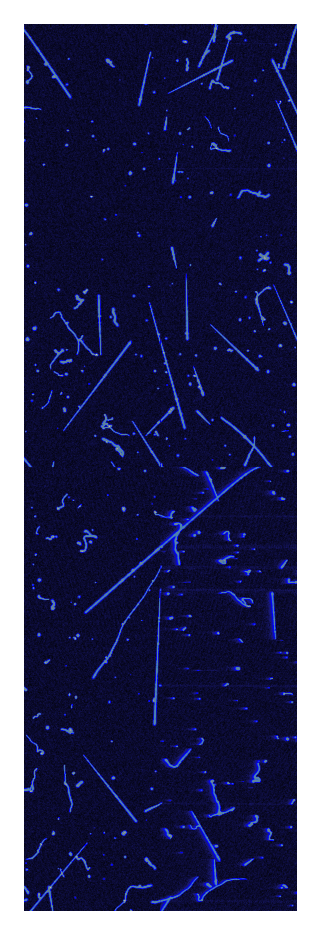

In [12]:
# Select and Load an Image
image_num = 0
test_image = fits.open(f'{data_dir}/{file_names[image_num]}')
print(f"Loaded {file_names[image_num]}")
# Extract median for each column to fix pre-scan effect
for i in range(4):
    test_image[i].data = test_image[i].data[:, 40:]

# Plot the image
fig, ax = plot_ccd_image(
    test_image,
    cmap=BLUE_CUBE_CMAP,
    remove_overscan=True,
    orientation="vertical",
    # value_map=lambda x: x*(x < 2000) + 2000*(x > 2000),
)

plt.show()
# fig.savefig("skipper_example_image.png")

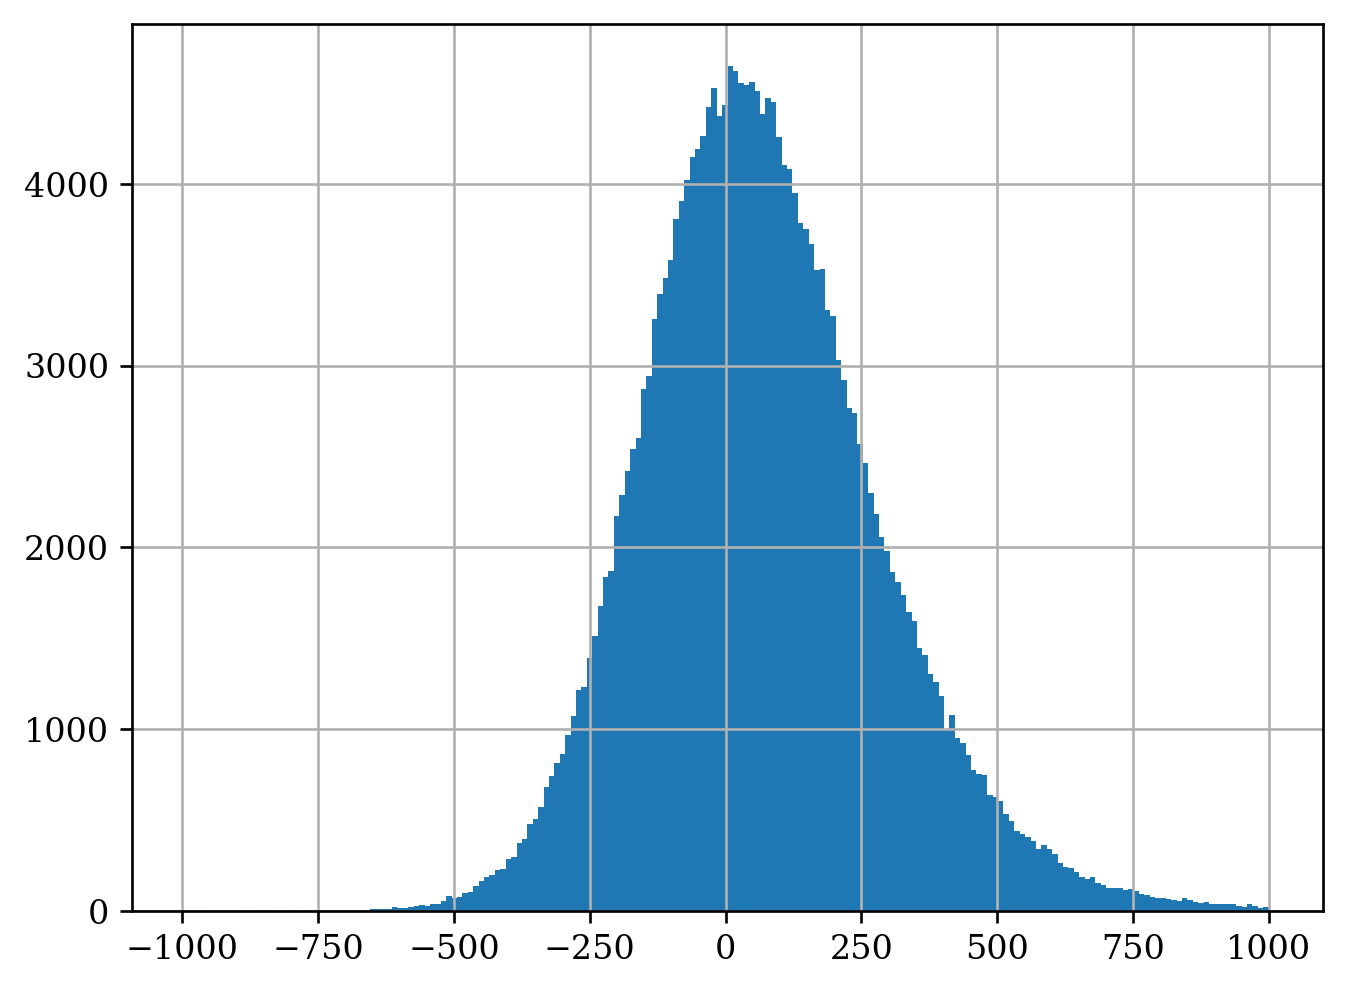

In [13]:
test_frame = test_image[1].data
test_data = test_frame.flatten()

plt.hist(test_data[np.abs(test_data) < 1e3], bins=200)
plt.grid()

plt.show()

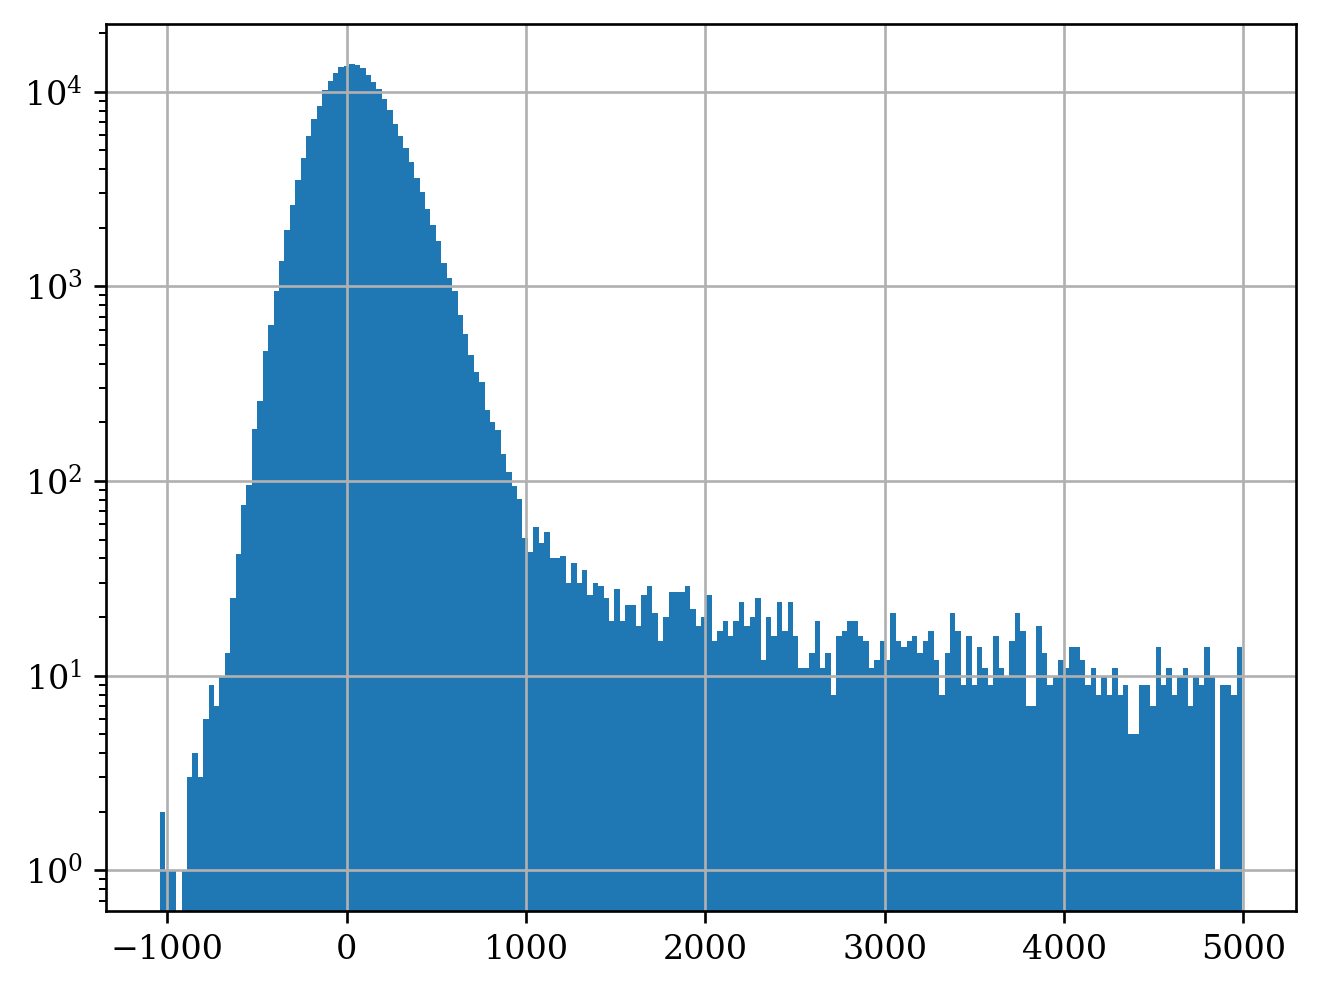

In [14]:
test_frame = test_image[1].data
test_data = test_frame.flatten()

plt.hist(test_data[np.abs(test_data) < 5e3], bins=200)
plt.grid()
# plt.xscale("log")
plt.yscale("log")

plt.show()

In [15]:
def mask_baseline_error(frame_vals: np.array) -> np.array:
    row_medians = np.median(frame_vals, axis=1)
    median_of_medians = np.median(row_medians)
    mad_of_medians = np.median(np.abs(row_medians - median_of_medians))
    outlier_cond = row_medians < (median_of_medians - 10 * mad_of_medians)
    frame_vals[outlier_cond] = np.nan
    return frame_vals

In [ ]:
# Test máscara baseline error
data_dict = {
    "standard": "TRAPS/29JUN2023",
    "shutter": "TRAPS/03JUL2023",
    "cloth": "TRAPS/13JUL2023"
}
for config in ["standard", "shutter", "cloth"]:
    files_in_dir = os.listdir(data_dict[config])
    exposure_values = np.arange(300, 1800+1, 300)  # s
    for m_exposure, exposure in enumerate(range(300, 1800+1, 300)):
        file_names = []
        for name in files_in_dir:
            if f"EXPOSURE{exposure}" in name:
                file_names.append(name)
        for n_file, file in enumerate(file_names):
            image = fits.open(f'{data_dict[config]}/{file}')
            for l_frame in range(4):
                frame_vals = image[l_frame].data
                frame_vals = mask_baseline_error(frame_vals)
                if np.isnan(frame_vals).any():
                    plt.imshow(np.log(np.abs(1 + frame_vals)))
                    plt.show()
                    break
                    # raise KeyboardInterrupt()

### Análisis de Fondo

In [17]:
data_dict = {
    "standard": "TRAPS/29JUN2023",
    "shutter": "TRAPS/03JUL2023",
    "cloth": "TRAPS/13JUL2023"
}
prescan_and_error_length = 40  # ~8 pixels from prescan + ~30 from an unknow error
config_results = dict()
config_images = dict()
for config in ["standard", "shutter", "cloth"]:
    # print(f"Reading {config}")
    files_in_dir = os.listdir(data_dict[config])
    exposure_values = np.arange(300, 1800+1, 300)  # s
    # exposure_results = [
    #     np.zeros((len(exposure_values), 6)) for _ in range(4)
    # ]
    median_images = []
    for m_exposure, exposure in enumerate(range(300, 1800+1, 300)):
        # print(f"Exposure: {exposure}")
        file_names = []
        for name in files_in_dir:
            if f"EXPOSURE{exposure}" in name:
                file_names.append(name)
        # print(*file_names, sep="\t")
        frame_image_array = [
            np.zeros((NROW, NCOL-OVERSCAN_LENGTH-prescan_and_error_length, len(file_names))) for _ in range(4)
        ]
        for n_file, file in enumerate(file_names):
            # print(file)
            image = fits.open(f'{data_dict[config]}/{file}')
            # print(f"Loaded {file}")
            # Extract median for each column to fix pre-scan effect
            # & remove overscan
            for i_frame in range(4):
                # print(image[i_frame].data.shape)
                # print(np.median(image[i_frame].data, axis=0, keepdims=True).shape)
                # raise KeyboardInterrupt()
                # image[i_frame].data -= np.median(image[i_frame].data[:, -OVERSCAN_LENGTH:], axis=1, keepdims=True)
                # image[i_frame].data -= np.median(image[i_frame].data, axis=0, keepdims=True)
                frame = image[i_frame].data[:, prescan_and_error_length:-OVERSCAN_LENGTH]
                frame = mask_baseline_error(frame)
                frame_image_array[i_frame][:, :, n_file] = frame
        median_frames = [np.nanmedian(hyperframe, axis=2) for hyperframe in frame_image_array]
        # median_frames = [hyperframe for hyperframe in frame_image_array]

        median_images.append(
            median_frames,
            # np.block([
            #     [median_frames[0], median_frames[1]],
            #     [median_frames[2], median_frames[3]],
            # ])
        )
        # remove pixels with values > 2_000
        # for i_frame, median_frame in enumerate(median_frames):
        #     median_frames[i_frame] = np.ma.masked_array(
        #         median_frame, 
        #         mask=(median_frame > 2_000),
        #         fill_value=np.nan,
        #     )
        # # remove 5% of the brightest pixels
        # for i_frame, median_frame in enumerate(median_frames):
        #     median_frames[i_frame] = np.ma.masked_array(
        #         median_frame, 
        #         mask=(median_frame > np.percentile(median_frame, 95))
        #     )
        # for i_frame, median_frame in enumerate(median_frames):
        #     exposure_results[i_frame][m_exposure, 0] = np.mean(median_frame.flatten())
        #     exposure_results[i_frame][m_exposure, 1] = np.std(median_frame.flatten(), ddof=1)
        #     exposure_results[i_frame][m_exposure, 2] = np.median(median_frame)
        #     # exposure_results[i_frame][m_exposure, 3] = np.nanquantile(
        #     #     np.abs(median_frame - np.median(median_frame)), 0.68,
        #     # )  # 68% CI centered at median
        #     # Limits of the 68% CI
        #     exposure_results[i_frame][m_exposure, 4] = np.nanquantile(median_frame.flatten(), 0.16)
        #     exposure_results[i_frame][m_exposure, 5] = np.nanquantile(median_frame.flatten(), 0.84)
    config_images[config] = median_images
    # config_results[config] = exposure_results

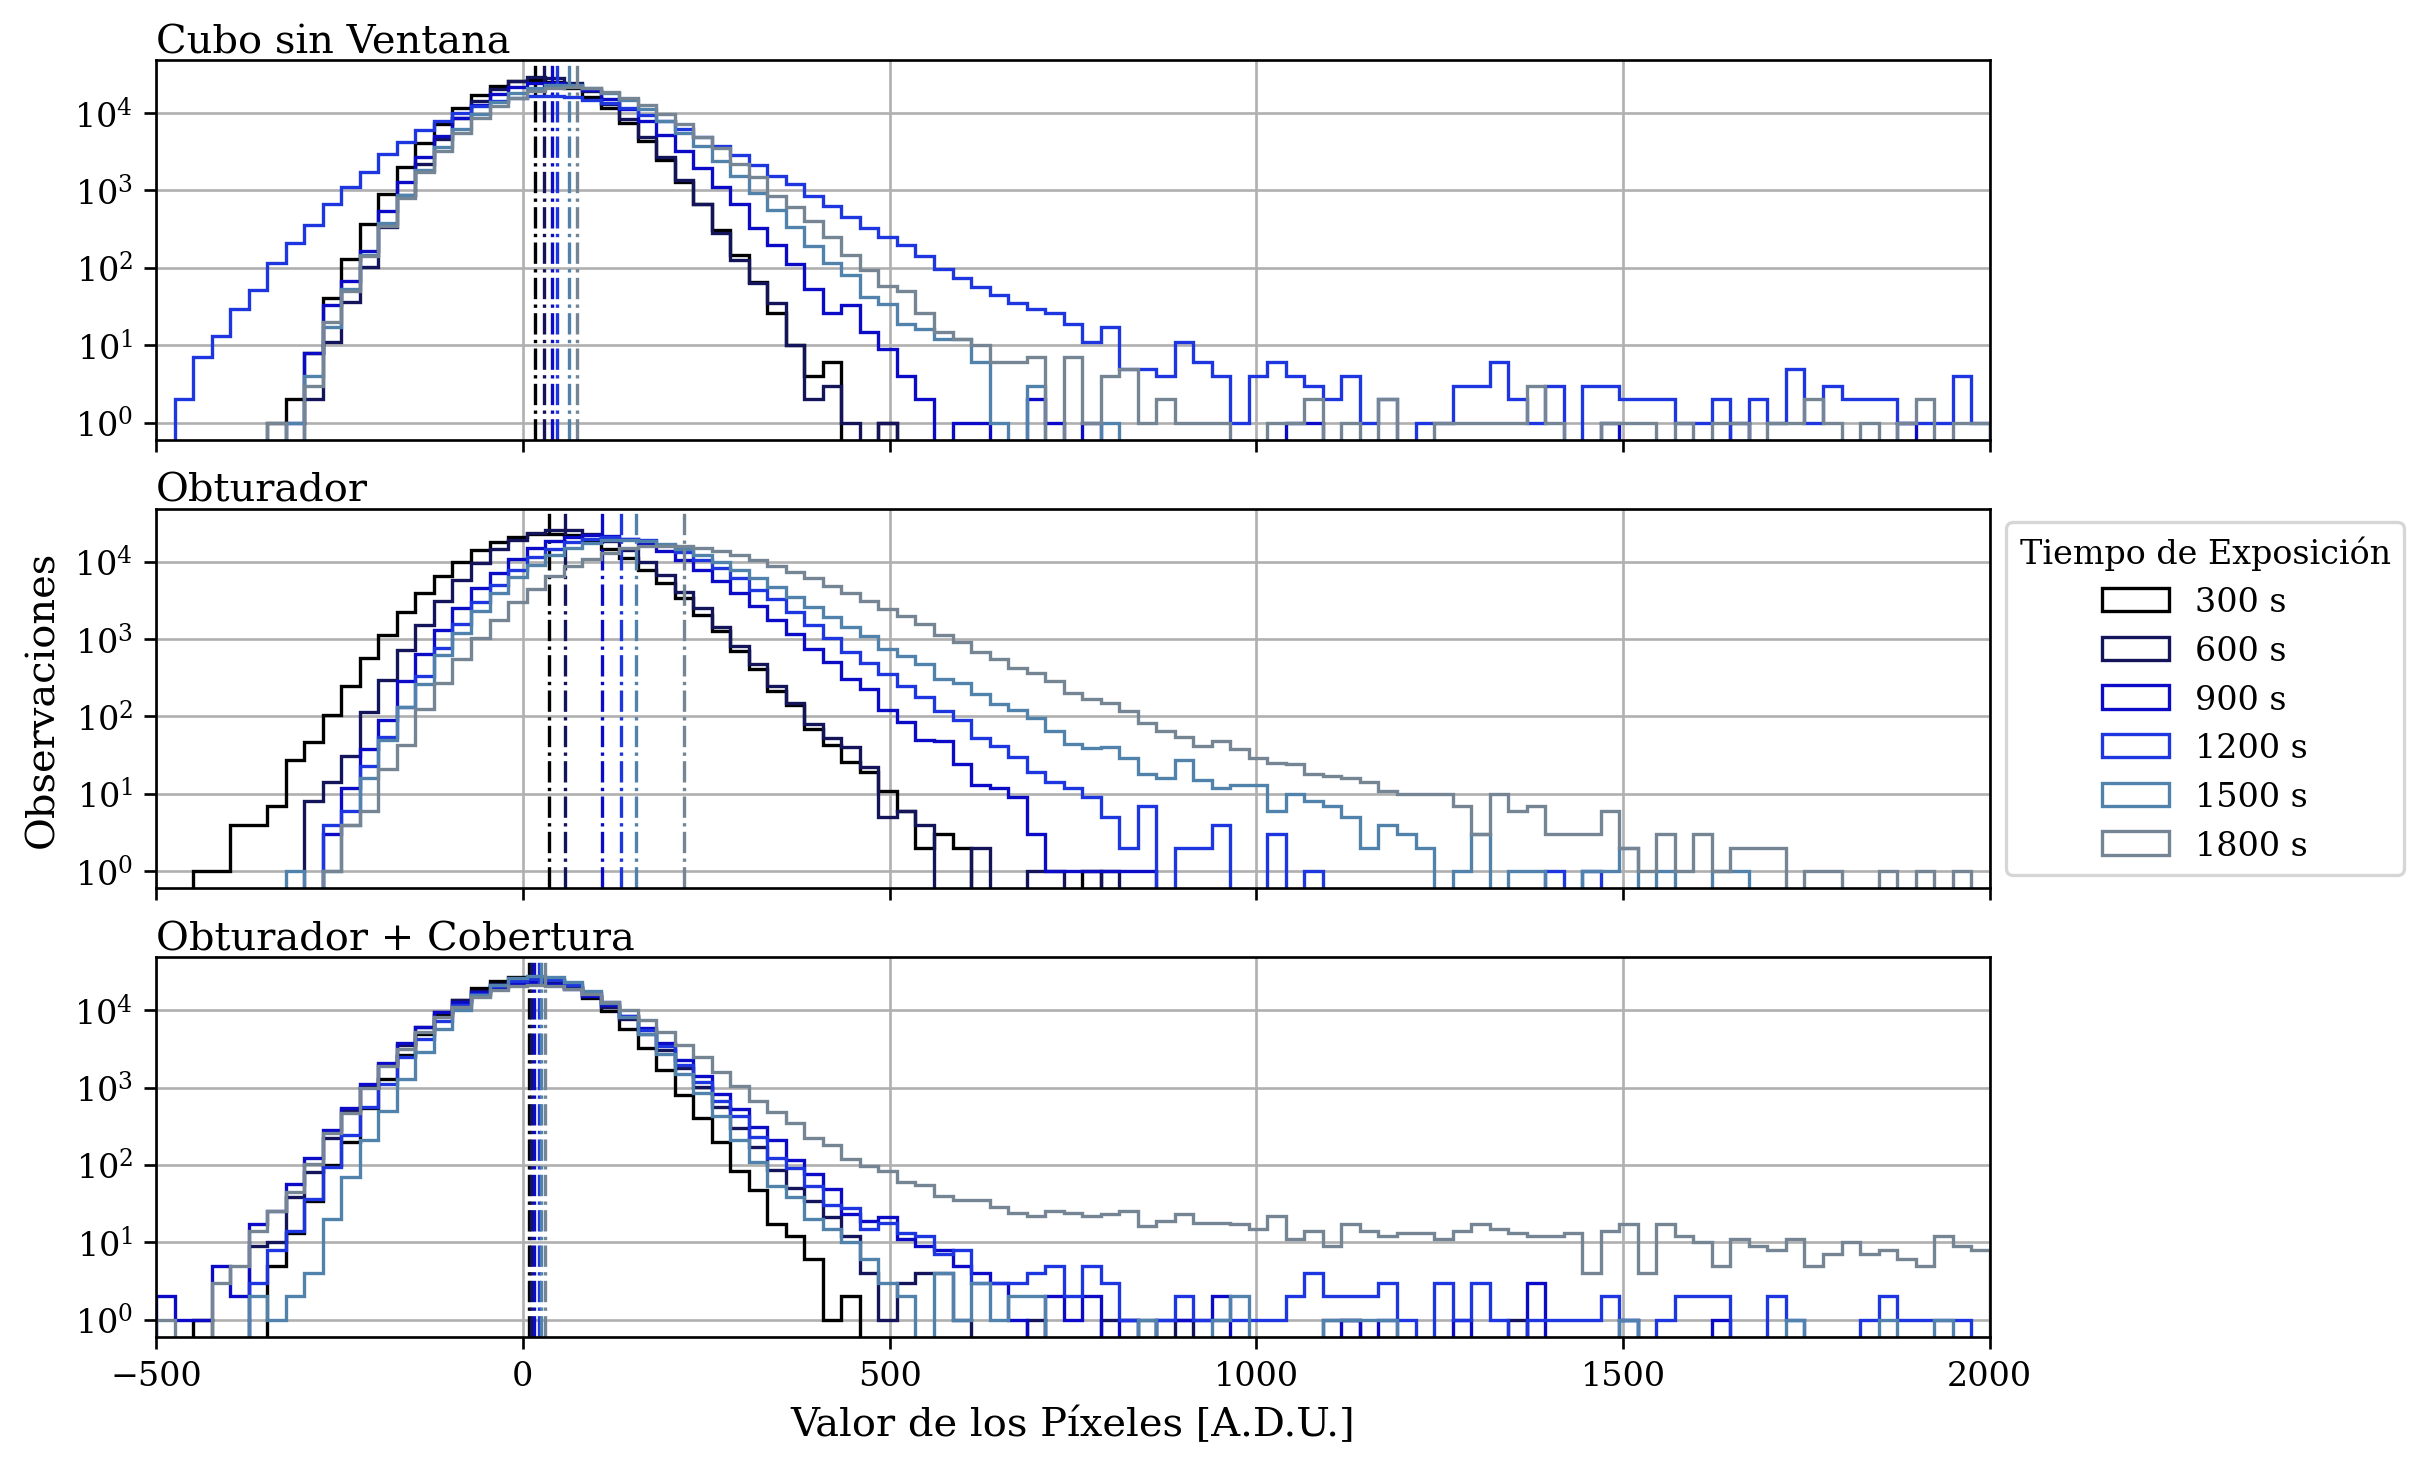

In [18]:
tags = {
    "standard": "Cubo sin Ventana",
    "shutter": "Obturador",
    "cloth": "Obturador + Cobertura",
}

norm = Normalize(300, 1.2*1800)
colorscale = plt.cm.ScalarMappable(norm, BLUE_CUBE_CMAP).to_rgba

min_val = -5e2
tope = 2e3
n_bins = 100
fig, axs = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
for ax, config in zip(axs, tags.keys()):
    for i, exposure in enumerate(np.arange(300, 1800+1, 300)):
        # if exposure in [1200]:
        #     continue
        test_data = config_images[config][i][0].flatten()
        test_data = test_data[~np.isnan(test_data)]
        ax.hist(
            test_data[np.abs(test_data) < tope],
            bins=np.linspace(min_val, tope, n_bins),
            histtype="step",
            label=f"{exposure} s",
            color=colorscale(exposure),
            
        )
        ax.axvline(np.nanmedian(test_data), ls="-.", c=colorscale(exposure), lw=1)
    ax.grid(True)
    ax.set_yscale("log")
    ax.set_yticks(10**np.arange(5))
    ax.set_xlim(min_val, tope)
    ax.set_title(tags[config], loc="left", pad=-1)  
    
ax.set_xlabel("Valor de los Píxeles [A.D.U.]")
axs[1].legend(title="Tiempo de Exposición", bbox_to_anchor=(1, 0.5), loc="center left")
axs[1].set_ylabel("Observaciones")
fig.savefig("median_images_dist.png", dpi=300)
plt.show()

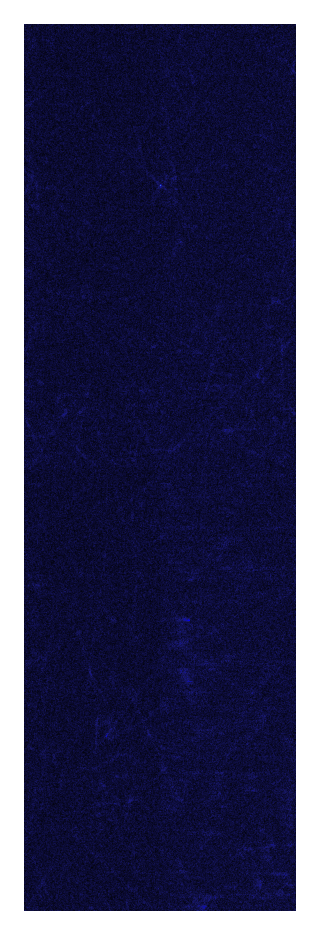

In [19]:
plot_ccd_image(config_images["standard"][-5], orientation="vertical")
plt.show()

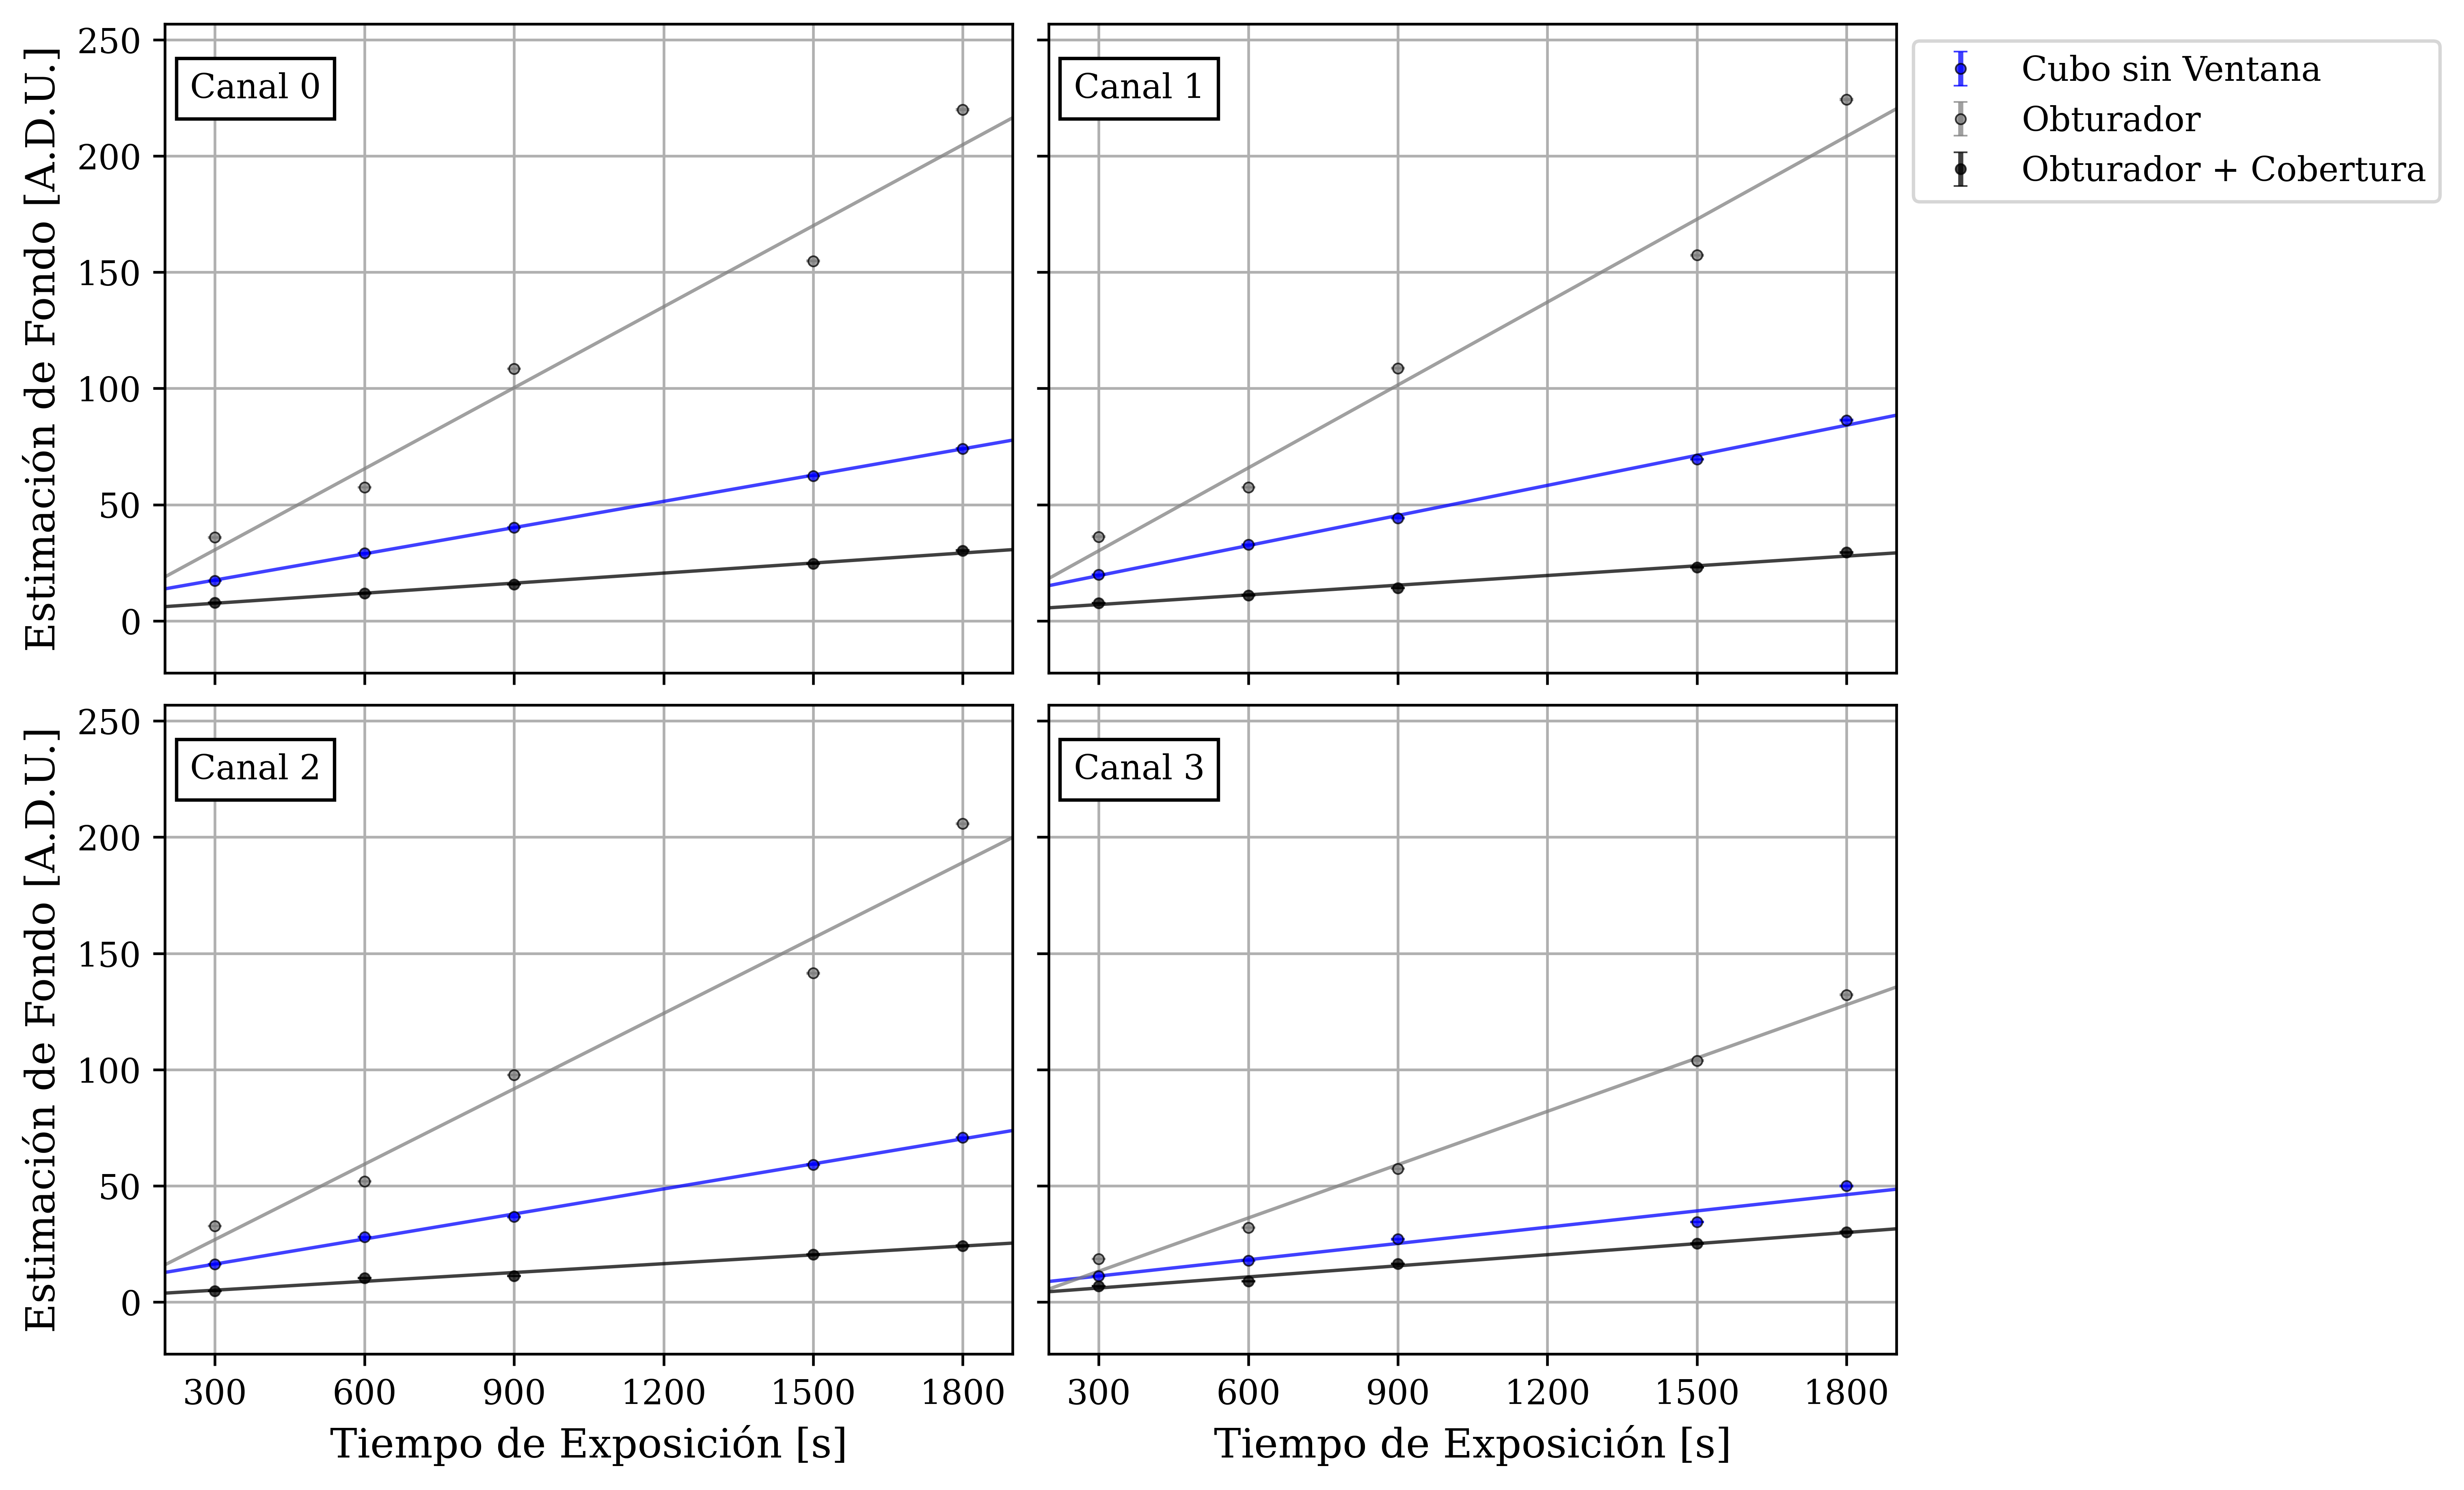

In [39]:
from scipy.optimize import curve_fit

color_dict = {
    "standard": "blue",
    "shutter": "gray",
    "cloth": "k",
}
tags = {
    "standard": "Cubo sin Ventana",
    "shutter": "Obturador",
    "cloth": "Obturador + Cobertura",
}

fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=300, sharex=True, sharey=True, constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    ax.text(250, 225, f"Canal {i}", bbox=dict(fc="w", ec="k"))
    ax.grid(True)
    if not i % 2:
        ax.set_ylabel("Estimación de Fondo [A.D.U.]")
    if i > 1:
        ax.set_xlabel("Tiempo de Exposición [s]")
    ax.set_xlim(200, 1800+100)
    ax.set_xticks(exposure_values)
    # ax.set_yticks(np.arange(-100, 300+1, 100))
# ax.set_ylim(-25, 300)

fit_params = dict()
exposures_filter = (exposure_values != 1200)# & (exposure_values != 1800)
for config in ["standard", "shutter", "cloth"]:
    pendientes = []
    for frame_idx, ax in enumerate(axs.flatten()):
        frame_pixel_list = [exp_frame_list[frame_idx].flatten() for exp_frame_list in config_images[config]]
        # pixel_list = [pixels[np.abs(pixels) < 2000] for pixels in pixel_list]
        # print(pixel_list)
        # y_vals = [np.nanmean(pixels) for pixels in pixel_list]
        y_vals = np.array([np.nanmedian(pixels) for pixels in frame_pixel_list])[exposures_filter]
        # y_err = [
        #     np.nanquantile(np.abs(pixels - np.median(pixels)), 0.68, method="closest_observation")
        #     for pixels in frame_pixel_list
        # ]  # 68% CI centered at median
        # y_err = np.array([
        #     np.nanmedian(np.abs(pixels - np.nanmedian(pixels)))
        #     for pixels in frame_pixel_list
        # ])[exposures_filter]
        filtered_frame_pixel_list = [
            pixels[pixels < np.nanquantile(pixels, 0.99)] for pixels in frame_pixel_list
        ]
        y_err = np.array([
            np.nanstd(pixels, ddof=1) / np.sqrt(np.sum(~np.isnan(pixels)))
            for pixels in filtered_frame_pixel_list
        ])[exposures_filter]
        popt, pcov = curve_fit(
            lambda x, a, b: a*x + b,
            (exposure_values[exposures_filter]),#+60*3),
            y_vals,
            sigma=y_err,
        )
        if frame_idx != 3:
            pendientes.append(popt[0])
        # print(f"{config}, frame {frame_idx}: {popt[0]:.3g} ± {np.sqrt(pcov[0, 0]):.1g}")
        ax.errorbar(
            x=(exposure_values[exposures_filter]),# + 60*3),  # Adding 3 minutes of average readout time
            y=y_vals, 
            yerr=y_err,
            fmt="o",
            color=color_dict[config],
            ms=3,
            markeredgecolor="k",
            markeredgewidth=0.5,
            alpha=0.75,
            ecolor=color_dict[config],
            capsize=2,
            label=tags[config],
        )
        ax.plot(
            [0, 1800+300],
            [popt[0]*i + popt[1] for i in [0, 1800+300]],
            color=color_dict[config],
            alpha=0.75,
            lw=1,
        )
        # ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
    fit_params[config] = np.mean(pendientes), np.std(pendientes, ddof=1)
axs[0, 1].legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.savefig("background_level.png", dpi=300)
plt.show()

In [33]:
for k, v in fit_params.items():
    print(f"{k}: {v[0]:.3f} ± {v[1]:.1g}")

standard: 0.039 ± 0.004
shutter: 0.114 ± 0.006
cloth: 0.014 ± 0.0009


# Análisis Viejo

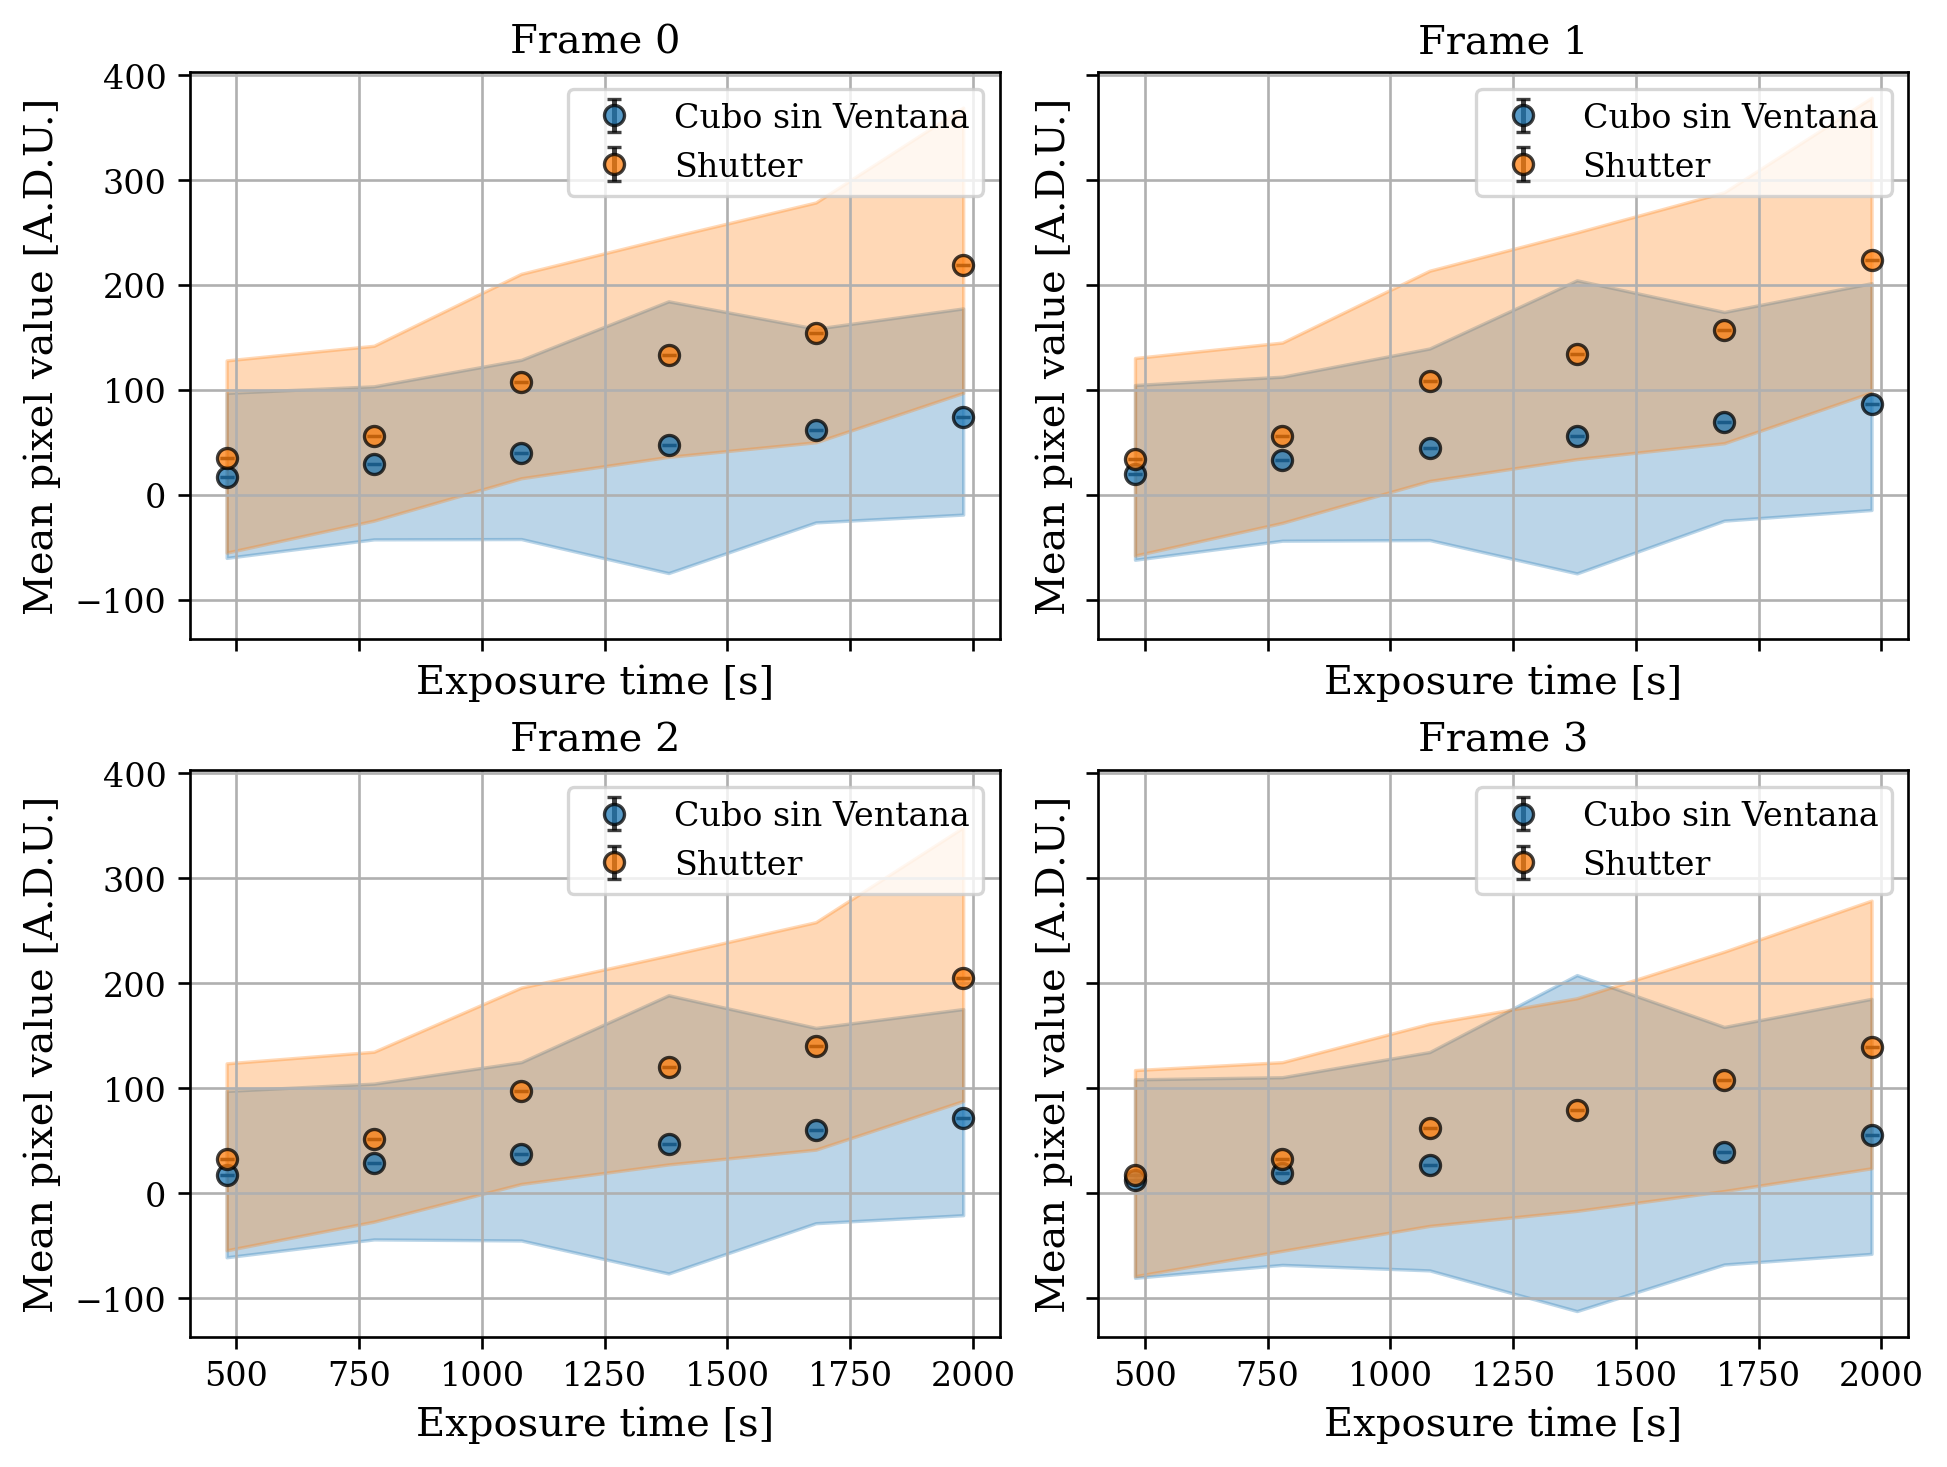

In [9]:
color_dict = {
    "standard": "C0",
    "shutter": "C1",
    "cloth": "C2",
}
tags = {
    "standard": "Cubo sin Ventana",
    "shutter": "Shutter",
    "cloth": "Shutter + Cobertura",
}

fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()
# axs = [axs[0]]*4
for i_frame, ax in enumerate(axs):
    for config in ["standard", "shutter", "cloth"][:2]:
        # ax.errorbar(
        #     x=(exposure_values + 60*3),  # Adding 3 minutes of average readout time
        #     y=config_results[config][i_frame][:, 0], 
        #     yerr=config_results[config][i_frame][:, 1]/np.sqrt(NROW*NCOL),
        #     fmt="o",
        #     color=color_dict[config],
        #     markeredgecolor="k",
        #     alpha=0.75,
        #     ecolor="k",
        #     capsize=2,
        #     label=tags[config],
        # )
        ax.fill_between(
            x=(exposure_values + 60*3),  # Adding 3 minutes of average readout time
            y1=config_results[config][i_frame][:, 4],
            y2=config_results[config][i_frame][:, 5],
            color=color_dict[config],
            alpha=0.3,
        )
        ax.errorbar(
            x=(exposure_values + 60*3),  # Adding 3 minutes of average readout time
            y=config_results[config][i_frame][:, 2], 
            yerr=config_results[config][i_frame][:, 3],
            fmt="o",
            # color="C" + str(int(color_dict[config][-1])+3),
            color=color_dict[config],
            markeredgecolor="k",
            alpha=0.75,
            ecolor="k",
            capsize=2,
            label=tags[config],
        )
    ax.grid(True)
    ax.legend()
    ax.set_title(f"Frame {i_frame}")
    ax.set_ylabel("Mean pixel value [A.D.U.]")
    ax.set_xlabel("Exposure time [s]")
plt.show()

0.03856643460440124 ± 0.0009973111953165054
0.11402477128099409 ± 0.009610091725847546
0.014000967157884976 ± 0.0008300337517063485


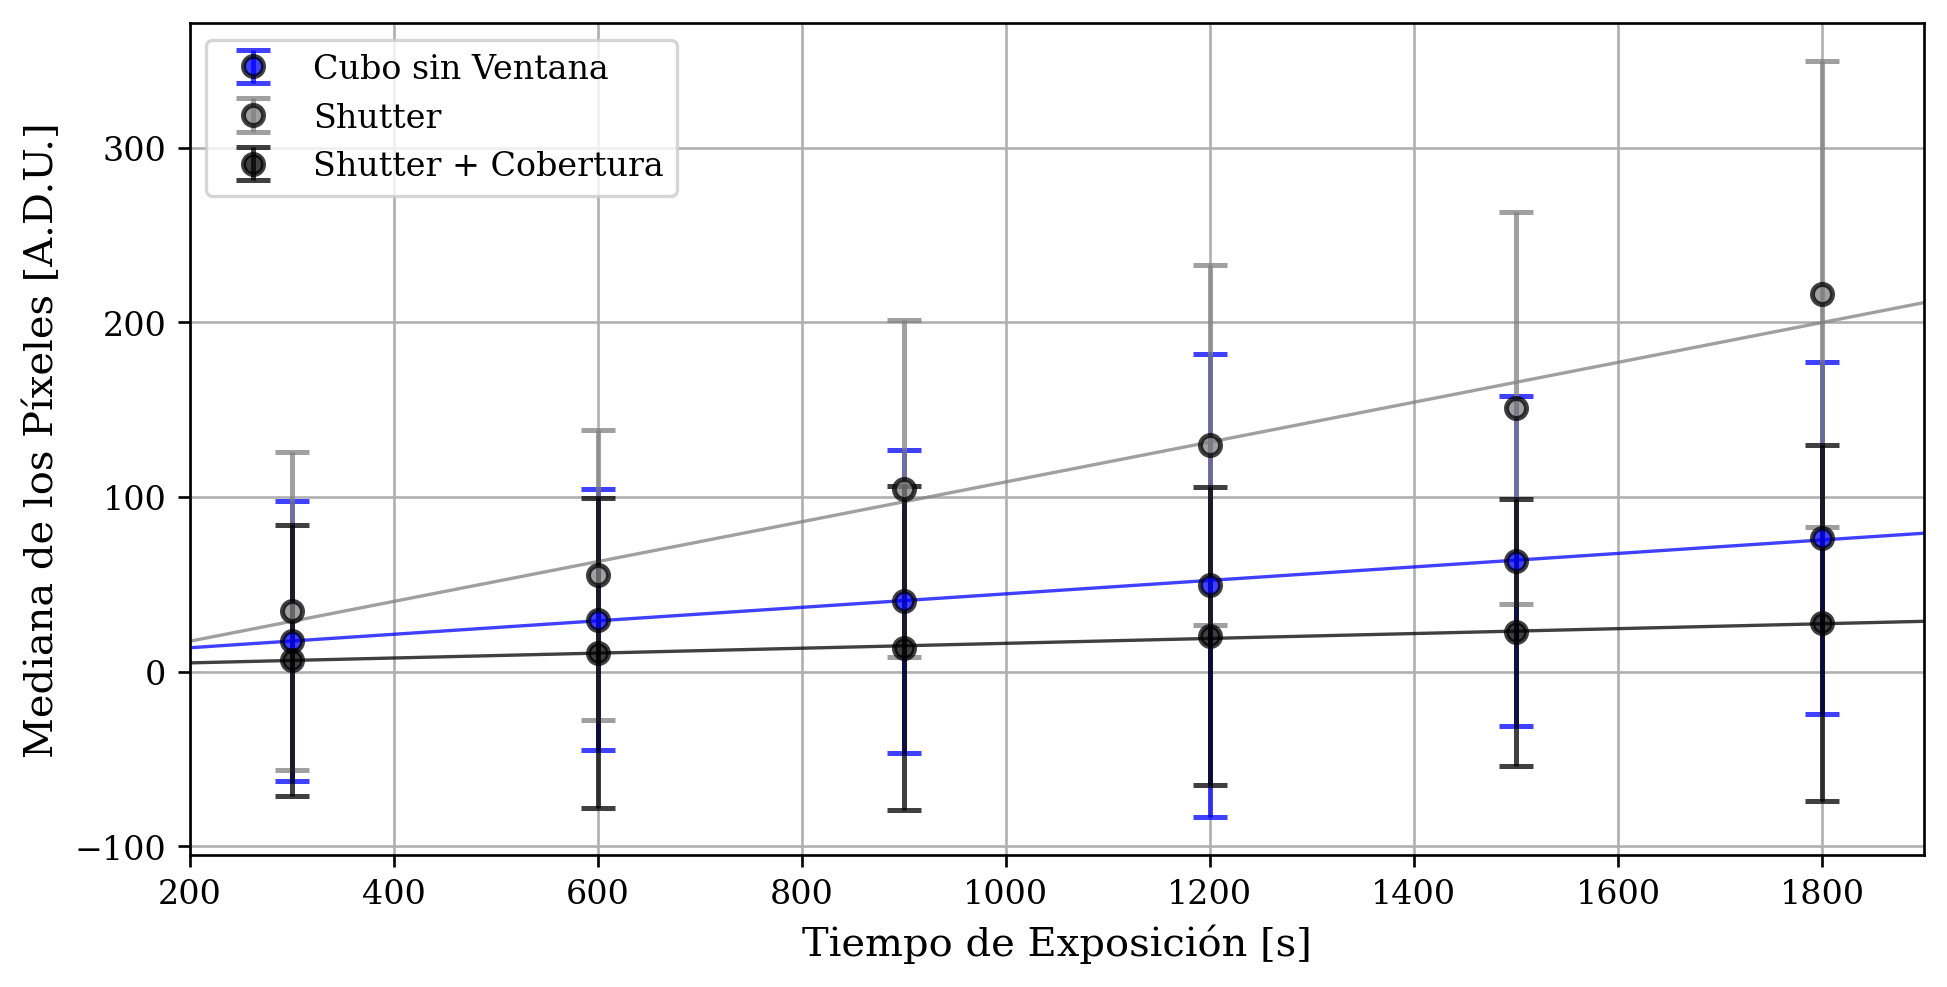

In [47]:
import seaborn as sns
from scipy.optimize import curve_fit

color_dict = {
    "standard": "blue",
    "shutter": "gray",
    "cloth": "k",
}
tags = {
    "standard": "Cubo sin Ventana",
    "shutter": "Shutter",
    "cloth": "Shutter + Cobertura",
}

imag_dims = config_images["standard"][0].shape
frame_dims = (imag_dims[0]//2, imag_dims[1]//2)
mask_last_frame = np.ones(imag_dims, dtype=bool)
mask_last_frame[frame_dims[0]:, frame_dims[1]:] = False

fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)
ax.grid(True)
ax.set_ylabel("Mediana de los Píxeles [A.D.U.]")
ax.set_xlabel("Tiempo de Exposición [s]")
ax.set_xlim(200, 1800+100)
# ax.set_ylim(-25, 300)

for config in ["standard", "shutter", "cloth"][:]:
    frame_pixel_list = [image[mask_last_frame] for image in config_images[config]]
    # pixel_list = [pixels[np.abs(pixels) < 2000] for pixels in pixel_list]
    # print(pixel_list)
    # y_vals = [np.nanmean(pixels) for pixels in pixel_list]
    y_vals = [np.nanmedian(pixels) for pixels in frame_pixel_list]
    y_err = [
        np.nanquantile(np.abs(pixels - np.median(pixels)), 0.68, method="closest_observation")
        for pixels in frame_pixel_list
    ]  # 68% CI centered at median
    # y_top = [np.nanquantile(pixels, 0.84, method="lower") for pixels in pixel_list]
    # y_bot = [np.nanquantile(pixels, 0.16, method="higher") for pixels in pixel_list]
    # y_err = [y_t - y_b for y_t, y_b in zip(y_top, y_bot)]
    # y_err = [
    #     np.nanstd(pixels, ddof=1)#/np.sqrt(pixels.size)
    #     for pixels in pixel_list
    # ]
    popt, pcov = curve_fit(
        lambda x, a, b: a*x + b,
        (exposure_values),#+60*3),
        y_vals,
        sigma=y_err
    )
    print(f"{popt[0]} ± {np.sqrt(pcov[0, 0])}")
    ax.errorbar(
        x=(exposure_values),# + 60*3),  # Adding 3 minutes of average readout time
        y=y_vals, 
        yerr=y_err,
        fmt="o",
        color=color_dict[config],
        markeredgecolor="k",
        markeredgewidth=1.5,
        alpha=0.75,
        ecolor=color_dict[config],
        capsize=5,
        label=tags[config],
    )
    ax.plot(
        [0, 1800+300],
        [popt[0]*i + popt[1] for i in [0, 1800+300]],
        color=color_dict[config],
        alpha=0.75,
        lw=1,
    )
    # ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
    ax.legend(loc="upper left")
    fig.savefig(f"{config}_background_level.png", dpi=300)
plt.show()